C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
313/313 - 21s - 66ms/step - accuracy: 0.3116 - loss: 1.9342 - val_accuracy: 0.3268 - val_loss: 1.8313
Epoch 2/50
313/313 - 15s - 48ms/step - accuracy: 0.3882 - loss: 1.7109 - val_accuracy: 0.4178 - val_loss: 1.6396
Epoch 3/50
313/313 - 15s - 47ms/step - accuracy: 0.4203 - loss: 1.6255 - val_accuracy: 0.4224 - val_loss: 1.6031
Epoch 4/50
313/313 - 20s - 64ms/step - accuracy: 0.4448 - loss: 1.5645 - val_accuracy: 0.4232 - val_loss: 1.6100
Epoch 5/50
313/313 - 16s - 50ms/step - accuracy: 0.4608 - loss: 1.5227 - val_accuracy: 0.4545 - val_loss: 1.5321
Epoch 6/50
313/313 - 15s - 49ms/step - accuracy: 0.4717 - loss: 1.4810 - val_accuracy: 0.4502 - val_loss: 1.5308
Epoch 7/50
313/313 - 19s - 60ms/step - accuracy: 0.4903 - loss: 1.4408 - val_accuracy: 0.4581 - val_loss: 1.5294
Epoch 8/50
313/313 - 16s - 52ms/step - accuracy: 0.4953 - loss: 1.4204 - val_accuracy: 0.4709 - val_loss: 1.4809
Epoch 9/50
313/313 - 17s - 54ms/step - accuracy: 0.5087 - loss: 1.3895 - val_accuracy: 0.4678 - 

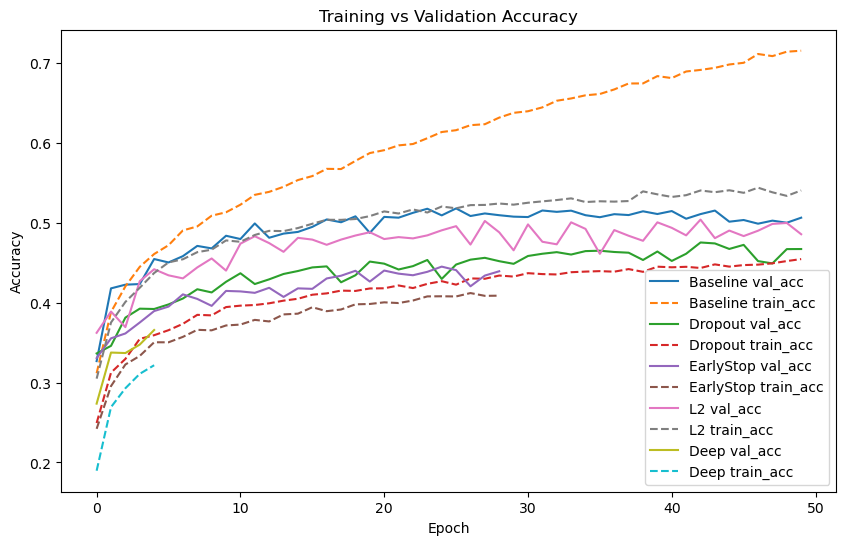

Baseline model test accuracy: 0.5042
Dropout model test accuracy: 0.4647
EarlyStop model test accuracy: 0.4379
L2 model test accuracy: 0.4925
Deep model test accuracy: 0.2805


In [1]:

# CIFAR-10 Dense NN with Regularization


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#  Load and preprocess CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten images for dense network
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# One-hot encode labels
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

# Split training into train + validation
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train_flat, y_train_cat, test_size=0.2, random_state=42
)

#  Function to build dense models
def build_dense_model(input_shape, hidden_layers=[512, 256], 
                      dropout_rate=0.0, l2_lambda=0.0):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    
    for units in hidden_layers:
        model.add(layers.Dense(units, activation='relu',
                               kernel_regularizer=regularizers.l2(l2_lambda)))
        if dropout_rate > 0.0:
            model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(10, activation='softmax'))
    return model

# Baseline model (no regularization)
baseline_model = build_dense_model(input_shape=(32*32*3,), hidden_layers=[512, 256])
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_baseline = baseline_model.fit(
    x_train_final, y_train_final,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=128,
    verbose=2
)

#  Model with dropout
dropout_model = build_dense_model(input_shape=(32*32*3,), hidden_layers=[512, 256], dropout_rate=0.3)
dropout_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_dropout = dropout_model.fit(
    x_train_final, y_train_final,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=128,
    verbose=2
)

# Model with early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
early_stop_model = build_dense_model(input_shape=(32*32*3,), hidden_layers=[512, 256], dropout_rate=0.3)
early_stop_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_early = early_stop_model.fit(
    x_train_final, y_train_final,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=2
)
print("Best epoch with early stopping:", early_stop.stopped_epoch - early_stop.patience + 1)

#  Model with L2 weight regularization
l2_model = build_dense_model(input_shape=(32*32*3,), hidden_layers=[512, 256], l2_lambda=0.001)
l2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_l2 = l2_model.fit(
    x_train_final, y_train_final,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=128,
    verbose=2
)

#  Deeper network model
deep_model = build_dense_model(input_shape=(32*32*3,), hidden_layers=[1024, 512, 256, 128], dropout_rate=0.3)
deep_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_deep = deep_model.fit(
    x_train_final, y_train_final,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=2
)

# Plot training vs validation accuracy
def plot_history(histories, labels):
    plt.figure(figsize=(10,6))
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'{label} val_acc')
        plt.plot(history.history['accuracy'], '--', label=f'{label} train_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.show()

plot_history(
    [history_baseline, history_dropout, history_early, history_l2, history_deep],
    ['Baseline', 'Dropout', 'EarlyStop', 'L2', 'Deep']
)

#  Evaluate on test set
models = [baseline_model, dropout_model, early_stop_model, l2_model, deep_model]
model_names = ['Baseline', 'Dropout', 'EarlyStop', 'L2', 'Deep']

for model, name in zip(models, model_names):
    test_loss, test_acc = model.evaluate(x_test_flat, y_test_cat, verbose=0)
    print(f"{name} model test accuracy: {test_acc:.4f}")
